#### Importación de librerias

## Reto de Data Science en Bluetab - Regresión y clasificación en dataset de otorgamiento de crédito

**Tags:** #datacleaning, #datapreprocessing, #featureengineering, # model

**Autor:** Alessio Daniel Hernández Rojas

**Última actualización:** 18-11-2025 (Creado: 18-11-2025)

**Descripción:** El presente script tiene como objetivo realizar: 1) Limpieza, 2) preprocesamiento de datos y 3) modelos de regresión y clasficación en una base de datos de otorgamiento de créditos bancarios.

**Entrada:** Base de datos cruda en formato .csv

**Salida:** NONE

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from datetime import datetime
from sklearn.ensemble import IsolationForest
import folium
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.dummy import DummyClassifier # Import the DummyClassifier class
from sklearn.metrics import auc

#### Funciones

In [71]:
# Renombre de columnas
def rename_cols(df,cols,prefix):
    new_feats=[prefix+col for col in cols]
    df=df.rename(columns=dict(zip(cols,new_feats)))
    return df

# Completitud
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

# Filtro de completitud
def filtrar_por_completitud(df, umbral=90):
    """
    Filtra las columnas de un DataFrame que tengan una completitud menor al umbral indicado.
    Imprime las columnas eliminadas junto con su porcentaje de completitud.
    Devuelve el DataFrame filtrado.
    """
    # Calcular completitud
    comple = pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple = comple.rename(columns={"index": "columna", 0: "total"})
    comple["completitud"] = (1 - comple["total"] / df.shape[0]) * 100

    # Identificar columnas que no cumplen el umbral
    eliminadas = comple.loc[comple["completitud"] < umbral, ["columna", "completitud"]]
    conservadas = comple.loc[comple["completitud"] >= umbral, "columna"]

    # Imprimir reporte
    if not eliminadas.empty:
        print("📉 Columnas eliminadas por baja completitud:")
        for _, row in eliminadas.iterrows():
            print(f" - {row['columna']}: {row['completitud']:.2f}% de completitud")
    else:
        print("✅ No se eliminaron columnas, todas cumplen el umbral.")

    # Retornar DataFrame filtrado
    return df[conservadas]

# Filtro de variables unarias ponderadas
def unarias_ponderadas(df, umbral=0.95, mostrar_sesgo=True):
    """
    Detecta variables en las que una categoría supera el umbral de proporción.
    Puede además mostrar el sesgo (distribución porcentual) de cada variable detectada.
    """
    unarias = []

    for v in df.columns:
        # Distribución de frecuencias relativas
        evaluacion = df[v].value_counts(normalize=True).reset_index()
        evaluacion.columns = [v, "proporcion"]

        # Verificar si la categoría dominante supera el umbral
        if evaluacion["proporcion"].iloc[0] > umbral:
            unarias.append(v)

            if mostrar_sesgo:
                print(f"\n🔍 Variable: {v}")
                print(evaluacion.to_string(index=False, formatters={"proporcion": "{:.2%}".format}))

    if not unarias:
        print("✅ No se encontraron variables unarias por encima del umbral.")

    return unarias


def descriptivos(df, tipo_variable = "v_"):
    for col in df.filter(like= tipo_variable ).columns:
        print(col)
        value_counts = df[col].value_counts(1)
        mydf = pd.DataFrame(value_counts)
        mydf['cumulativo'] = df[col].value_counts().cumsum() / df[col].value_counts().sum()
        mydf['total'] = df[col].value_counts()
        mydf['total_cumulativo'] = df[col].value_counts().cumsum()
        display(mydf)
        print()
        print("\n")


def plot_eda_cat(df, prefix, title):
    """
    Grafica variables categóricas (que comienzan con 'prefix') como barras horizontales.
    Muestra frecuencias y porcentajes, ajustando la altura según el número de categorías.
    """

    # Filtrar columnas que empiezan con el prefijo
    lista_categoricas = [col for col in df.columns if col.startswith(prefix)]

    for current_cat in lista_categoricas:
        # Frecuencias absolutas y totales
        counts = df[current_cat].value_counts().sort_values(ascending=True)
        total = counts.sum()

        # Altura dinámica según número de categorías
        n_cat = len(counts)
        fig_height = max(400, 30 * n_cat + 150)

        # Gráfico de barras
        fig = go.Figure([
            go.Bar(
                x=counts.values,
                y=counts.index,
                orientation='h',
                text=[f"{v} ({v/total*100:.1f}%)" for v in counts],
                textposition='auto',
                marker=dict(color='steelblue')
            )
        ])

        # Diseño
        fig.update_layout(
            title=dict(text=f"<b>{title} – {current_cat}</b>", x=0.5, font=dict(size=20)),
            xaxis_title="Frecuencia",
            yaxis_title="Categoría",
            width=800,
            height=fig_height,
            margin=dict(t=80, l=180, r=50, b=60),
            showlegend=False,
            template="plotly_white"
        )

        # Mostrar todas las categorías en el eje Y
        fig.update_yaxes(tickmode='array', tickvals=list(counts.index), ticktext=list(counts.index))

        fig.show()



def plot_eda_num(df, prefix='num_', titulo='Exploratory Data Analysis (EDA)'):
    """
    Genera histogramas con curva KDE + boxplot (abajo) para todas las variables numéricas 
    cuyo nombre contiene el prefijo indicado, mostrando una leyenda independiente
    dentro de cada subplot.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con las variables a analizar.
    prefix : str, opcional (por defecto 'num_')
        Prefijo que deben tener las columnas numéricas a analizar.
    titulo : str, opcional
        Título general mostrado en cada figura.
    """

    # --- Solo columnas que COMIENZAN con el prefijo ---
    lista_numericas = [col for col in df.columns if col.startswith(prefix)]
    print(f"Total de variables que cumplen con '{prefix}': {len(lista_numericas)}\n")

    for col in lista_numericas:
        x = df[col].dropna()

        # --- Histograma (densidad normalizada) ---
        hist_vals, bin_edges = np.histogram(x, bins=38, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # --- KDE ---
        kde = gaussian_kde(x)
        kde_x = np.linspace(x.min(), x.max(), 500)
        kde_y = kde(kde_x)

        # --- Estadísticos descriptivos ---
        skew = df[col].skew()
        mean = df[col].mean()
        median = df[col].median()

        # --- Subplots: histograma + boxplot ---
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            row_heights=[0.75, 0.25],
            vertical_spacing=0.08
        )

        # --- Histograma ---
        fig.add_trace(go.Bar(
            x=bin_centers,
            y=hist_vals,
            name="Histograma",
            marker=dict(color='rgba(70,130,180,0.7)', line=dict(color='white', width=1)),
            hovertemplate='Valor: %{x:.2f}<br>Densidad: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- KDE ---
        fig.add_trace(go.Scatter(
            x=kde_x,
            y=kde_y,
            mode="lines",
            name="KDE",
            line=dict(color="red", width=2, dash="dash"),
            hovertemplate='Valor: %{x:.2f}<br>Densidad KDE: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- Boxplot (abajo) ---
        fig.add_trace(go.Box(
            x=x,
            name="Boxplot",
            boxmean=True,
            marker_color='rgba(255,165,0,0.7)',
            line=dict(width=1),
            orientation='h',
            showlegend=False
        ), row=2, col=1)

        # --- Diseño ---
        fig.update_layout(
            title=dict(
                text=f"<b>{titulo} - {col}</b><br>Media: {mean:.2f}, Mediana: {median:.2f}, Asimetría: {skew:.2f}",
                x=0.5,
                font=dict(size=18)
            ),
            xaxis_title=col,
            yaxis_title="Densidad (escala normalizada)",
            yaxis_tickformat='.1e',  # notación científica (tipo 20n, 40n)
            width=800,
            height=600,
            template="plotly_white",
            showlegend=True,
            # 👇 Leyenda dentro del primer subplot
            legend=dict(
                x=0.98, y=0.95,
                xanchor='right', yanchor='top',
                bgcolor='rgba(255,255,255,0.6)',
                bordercolor='gray',
                borderwidth=1,
                font=dict(size=12)
            ),
            margin=dict(t=100, l=70, r=40, b=70)
        )

        fig.update_yaxes(title_text="Boxplot", row=2, col=1, showticklabels=False)
        fig.show()

# Plot matriz de correlación
def plot_corr_matrix(df, prefix, title="Matriz de correlación"):
    """
    Muestra un mapa de calor triangular inferior (sin diagonal)
    con los valores de correlación para variables que inician con 'prefix',
    ocultando los NaN y con etiquetas en negritas.
    """
    # Filtrar columnas que comienzan con el prefijo
    cols = [c for c in df.columns if c.startswith(prefix)]
    df_sub = df[cols]

    # Calcular matriz de correlación
    corr = df_sub.corr(numeric_only=True)

    # Máscara: mostrar solo la parte inferior (sin diagonal)
    mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
    corr_masked = corr.where(mask)

    # Reemplazar NaN por None para que no se muestren en el heatmap
    z_vals = corr_masked.where(~corr_masked.isna(), None)

    # Crear figura
    fig = go.Figure(
        data=go.Heatmap(
            z=z_vals.values,
            x=corr_masked.columns,
            y=corr_masked.index,
            colorscale="RdBu",
            zmin=-1, zmax=1,
            text=corr_masked.round(2).astype(str).replace("nan", ""),
            texttemplate="%{text}",
            textfont={"size": 14},
            hoverongaps=False,
            colorbar=dict(title="Correlación")
        )
    )

    # Ajustar layout
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", x=0.5, font=dict(size=18)),
        xaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            tickangle=45,
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        yaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            autorange="reversed",
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        width=800,
        height=800,
        margin=dict(l=100, r=50, t=80, b=100)
    )

    fig.show()

# EDA completo
def compute_EDA(df):
  df_eda = df.copy()
  print("Dimensiones del dataset:", df_eda.shape)
  plot_eda_cat(df_eda, prefix='cat_', title='Distribución en Variables Categoricas')
  plot_eda_num(df_eda, prefix='num_', titulo='Distribuciones en Variables Numéricas')
  plot_corr_matrix(df_eda, prefix='num_', title='Matriz de Correlación para Variables Numéricas')
  completitud_df = completitud(df_eda)
  display(completitud_df)



# Detección y eliminación de outliers con Isolation Forest
def remove_outliers_iforest(df, prefix='num_', contamination=0.02, random_state=42):
    # Filtrar columnas numéricas
    num_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[num_cols].dropna()

    # Modelo
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(X)

    # Filtrar outliers (preds = -1 son outliers)
    df_filtered = df.loc[X.index[preds == 1]]

    print(f"✅ Registros conservados: {len(df_filtered)} / {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
    return df_filtered

#### Lectura de dataset 

In [72]:
# Cargar el dataset de inmuebles en Cuahutemoc, CDMX
df = pd.read_csv('data/default_of_credit_card_clients.csv', header=1)
display(df.head())

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

#### Exploración cruda de dataset

In [73]:
# Tamaño del dataset
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (30000, 25)


In [74]:
# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

                       columna  total  completitud
0                           ID      0        100.0
1                     PAY_AMT5      0        100.0
2                     PAY_AMT4      0        100.0
3                     PAY_AMT3      0        100.0
4                     PAY_AMT2      0        100.0
5                     PAY_AMT1      0        100.0
6                    BILL_AMT6      0        100.0
7                    BILL_AMT5      0        100.0
8                    BILL_AMT4      0        100.0
9                    BILL_AMT3      0        100.0
10                   BILL_AMT2      0        100.0
11                    PAY_AMT6      0        100.0
12                   BILL_AMT1      0        100.0
13                       PAY_5      0        100.0
14                       PAY_4      0        100.0
15                       PAY_3      0        100.0
16                       PAY_2      0        100.0
17                       PAY_0      0        100.0
18                         AGE 

In [75]:
# Descripción estadística del dataset
display(df.describe())

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default payment next month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000  

[8 rows x 25 columns]

#### Renombrado de características

In [76]:
# Identificación de nombres de columnas
print(df.dtypes)

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


In [77]:
# Reemplazo de espacios en los nombres de columnas por guiones bajos
df.columns = df.columns.str.replace(' ', '_')

In [78]:
# Mapeo manual de variables de acuerdo a tipo de solución
df_reg = df.copy()
df_clasif = df.copy()

# Eliminar df de la memoria
del df

In [79]:
# Mapeo manual de variables de acuerdo a tipo
id_feats = ['ID']
date_feats = []
num_feats = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']
cat_feats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default_payment_next_month']
text_feats = []
geo_feats = []
tgt_feats = ['PAY_AMT4']

# Renombrado aplicado 
df_reg=rename_cols(df_reg, id_feats,"id_")
df_reg=rename_cols(df_reg, date_feats,"date_")
df_reg=rename_cols(df_reg, num_feats,"num_")
df_reg=rename_cols(df_reg, cat_feats,"cat_")
df_reg=rename_cols(df_reg, text_feats,"text_")
df_reg=rename_cols(df_reg, geo_feats,"geo_")
df_reg=rename_cols(df_reg, tgt_feats,"tgt_")

# Completitud del dataset
completitud_df = completitud(df_reg)
print(completitud_df)

                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     tgt_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17        

In [80]:
# Mapeo manual de variables de acuerdo a tipo
id_feats = ['ID']
date_feats = []
num_feats = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_feats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
text_feats = []
geo_feats = []
tgt_feats = ['default_payment_next_month']

# Renombrado aplicado 
df_clasif=rename_cols(df_clasif, id_feats,"id_")
df_clasif=rename_cols(df_clasif, date_feats,"date_")
df_clasif=rename_cols(df_clasif, num_feats,"num_")
df_clasif=rename_cols(df_clasif, cat_feats,"cat_")
df_clasif=rename_cols(df_clasif, text_feats,"text_")
df_clasif=rename_cols(df_clasif, geo_feats,"geo_")
df_clasif=rename_cols(df_clasif, tgt_feats,"tgt_")

# Completitud del dataset
completitud_df = completitud(df_clasif)
print(completitud_df)

                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17        

In [81]:
# Tipos de datos
for df in [df_reg, df_clasif]:
    print(df.dtypes)

id_ID                             int64
num_LIMIT_BAL                     int64
cat_SEX                           int64
cat_EDUCATION                     int64
cat_MARRIAGE                      int64
num_AGE                           int64
cat_PAY_0                         int64
cat_PAY_2                         int64
cat_PAY_3                         int64
cat_PAY_4                         int64
cat_PAY_5                         int64
cat_PAY_6                         int64
num_BILL_AMT1                     int64
num_BILL_AMT2                     int64
num_BILL_AMT3                     int64
num_BILL_AMT4                     int64
num_BILL_AMT5                     int64
num_BILL_AMT6                     int64
num_PAY_AMT1                      int64
num_PAY_AMT2                      int64
num_PAY_AMT3                      int64
tgt_PAY_AMT4                      int64
num_PAY_AMT5                      int64
num_PAY_AMT6                      int64
cat_default_payment_next_month    int64


No hay necesidad de cambiar tipo de dato

#### Eliminación de Duplicados

In [82]:
def limpiar_duplicados(df):
    # Duplicados generales
    duplicados = df[df.duplicated(keep=False)]
    print(f"Número de duplicados generales: {duplicados.shape[0]}")
    df = df.drop_duplicates(keep='first')
    print(f"DataFrame sin duplicados generales. Total de filas: {df.shape[0]}\n")

    # Duplicados específicos por id
    duplicados = df[df.duplicated(subset=["id_ID"], keep=False)]
    print(f"Número de duplicados específicos en 'id_ID': {duplicados.shape[0]}")
    df = df.drop_duplicates(subset=["id_ID"], keep='first')
    print(f"DataFrame sin duplicados en 'id_ID'. Total de filas: {df.shape[0]}\n")

    return df

df_reg = limpiar_duplicados(df_reg)
df_clasif = limpiar_duplicados(df_clasif)

Número de duplicados generales: 0
DataFrame sin duplicados generales. Total de filas: 30000

Número de duplicados específicos en 'id_ID': 0
DataFrame sin duplicados en 'id_ID'. Total de filas: 30000

Número de duplicados generales: 0
DataFrame sin duplicados generales. Total de filas: 30000

Número de duplicados específicos en 'id_ID': 0
DataFrame sin duplicados en 'id_ID'. Total de filas: 30000



#### Eliminación de variables por completitud

In [83]:
def procesar_completitud(df, umbral=80):
    # Filtrar columnas con completitud bajo el umbral
    df = filtrar_por_completitud(df, umbral=umbral)

    # Calcular completitud final
    completitud_df = completitud(df)
    print(completitud_df)

    return df

df_reg = procesar_completitud(df_reg, umbral=80)
df_clasif = procesar_completitud(df_clasif, umbral=80)

✅ No se eliminaron columnas, todas cumplen el umbral.
                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     tgt_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16         

In [84]:
display(df_reg)

id_ID  num_LIMIT_BAL  cat_SEX  cat_EDUCATION  cat_MARRIAGE  num_AGE  \
0          1          20000        2              2             1       24   
1          2         120000        2              2             2       26   
2          3          90000        2              2             2       34   
3          4          50000        2              2             1       37   
4          5          50000        1              2             1       57   
...      ...            ...      ...            ...           ...      ...   
29995  29996         220000        1              3             1       39   
29996  29997         150000        1              3             2       43   
29997  29998          30000        1              2             2       37   
29998  29999          80000        1              3             1       41   
29999  30000          50000        1              2             1       46   

       cat_PAY_0  cat_PAY_2  cat_PAY_3  cat_PAY_4  ...  num_BILL_AMT4  \
0              2          2         -1         -1  ...              0   
1             -1          2          0          0  ...           3272   
2              0          0          0          0  ...          14331   
3              0          0          0          0  ...          28314   
4             -1          0         -1          0  ...          20940   
...          ...        ...        ...        ...  ...            ...   
29995          0          0          0          0  ...          88004   
29996         -1         -1         -1         -1  ...           8979   
29997          4          3          2         -1  ...          20878   
29998          1         -1          0          0  ...          52774   
29999          0          0          0          0  ...          36535   

       num_BILL_AMT5  num_BILL_AMT6  num_PAY_AMT1  num_PAY_AMT2  num_PAY_AMT3  \
0                  0              0             0           689             0   
1               3455           3261             0          1000          1000   
2              14948          15549          1518          1500          1000   
3              28959          29547          2000          2019          1200   
4              19146          19131          2000         36681         10000   
...              ...            ...           ...           ...           ...   
29995          31237          15980          8500         20000          5003   
29996           5190              0          1837          3526          8998   
29997          20582          19357             0             0         22000   
29998          11855          48944         85900          3409          1178   
29999          32428          15313          2078          1800          1430   

       tgt_PAY_AMT4  num_PAY_AMT5  num_PAY_AMT6  \
0                 0             0             0   
1              1000             0          2000   
2              1000          1000          5000   
3              1100          1069          1000   
4              9000           689           679   
...             ...           ...           ...   
29995          3047          5000          1000   
29996           129             0             0   
29997          4200          2000          3100   
29998          1926         52964          1804   
29999          1000          1000          1000   

       cat_default_payment_next_month  
0                                   1  
1                                   1  
2                                   0  
3                                   0  
4                                   0  
...                               ...  
29995                               0  
29996                               0  
29997                               1  
29998                               1  
29999                               1  

[30000 rows x 25 columns]

#### Eliminación de variables categoricas unitarias

In [85]:
def procesar_unarias(df, umbral=0.9):
    # Eliminación de variables categoricas unitarias
    unarias = unarias_ponderadas(df, umbral)
    print(unarias)
    # si deseas eliminar esas columnas:
    df = df.drop(columns=unarias)
    return df

df_reg = procesar_unarias(df_reg, 0.9)
df_clasif = procesar_unarias(df_clasif, 0.9)

✅ No se encontraron variables unarias por encima del umbral.
[]
✅ No se encontraron variables unarias por encima del umbral.
[]


#### Descriptivos de variables categóricos

In [86]:
# Descriptivos categóricos
for df in [df_reg, df_clasif]:
    descriptivos(df, tipo_variable = "cat_")

cat_SEX


proportion  cumulativo  total  total_cumulativo
cat_SEX                                                 
2          0.603733    0.603733  18112             18112
1          0.396267    1.000000  11888             30000




cat_EDUCATION


proportion  cumulativo  total  total_cumulativo
cat_EDUCATION                                                 
2                0.467667    0.467667  14030             14030
1                0.352833    0.820500  10585             24615
3                0.163900    0.984400   4917             29532
5                0.009333    0.993733    280             29812
4                0.004100    0.997833    123             29935
6                0.001700    0.999533     51             29986
0                0.000467    1.000000     14             30000




cat_MARRIAGE


proportion  cumulativo  total  total_cumulativo
cat_MARRIAGE                                                 
2               0.532133    0.532133  15964             15964
1               0.455300    0.987433  13659             29623
3               0.010767    0.998200    323             29946
0               0.001800    1.000000     54             30000




cat_PAY_0


proportion  cumulativo  total  total_cumulativo
cat_PAY_0                                                 
 0           0.491233    0.491233  14737             14737
-1           0.189533    0.680767   5686             20423
 1           0.122933    0.803700   3688             24111
-2           0.091967    0.895667   2759             26870
 2           0.088900    0.984567   2667             29537
 3           0.010733    0.995300    322             29859
 4           0.002533    0.997833     76             29935
 5           0.000867    0.998700     26             29961
 8           0.000633    0.999333     19             29980
 6           0.000367    0.999700     11             29991
 7           0.000300    1.000000      9             30000




cat_PAY_2


proportion  cumulativo  total  total_cumulativo
cat_PAY_2                                                 
 0           0.524333    0.524333  15730             15730
-1           0.201667    0.726000   6050             21780
 2           0.130900    0.856900   3927             25707
-2           0.126067    0.982967   3782             29489
 3           0.010867    0.993833    326             29815
 4           0.003300    0.997133     99             29914
 1           0.000933    0.998067     28             29942
 5           0.000833    0.998900     25             29967
 7           0.000667    0.999567     20             29987
 6           0.000400    0.999967     12             29999
 8           0.000033    1.000000      1             30000




cat_PAY_3


proportion  cumulativo  total  total_cumulativo
cat_PAY_3                                                 
 0           0.525467    0.525467  15764             15764
-1           0.197933    0.723400   5938             21702
-2           0.136167    0.859567   4085             25787
 2           0.127300    0.986867   3819             29606
 3           0.008000    0.994867    240             29846
 4           0.002533    0.997400     76             29922
 7           0.000900    0.998300     27             29949
 6           0.000767    0.999067     23             29972
 5           0.000700    0.999767     21             29993
 1           0.000133    0.999900      4             29997
 8           0.000100    1.000000      3             30000




cat_PAY_4


proportion  cumulativo  total  total_cumulativo
cat_PAY_4                                                 
 0           0.548500    0.548500  16455             16455
-1           0.189567    0.738067   5687             22142
-2           0.144933    0.883000   4348             26490
 2           0.105300    0.988300   3159             29649
 3           0.006000    0.994300    180             29829
 4           0.002300    0.996600     69             29898
 7           0.001933    0.998533     58             29956
 5           0.001167    0.999700     35             29991
 6           0.000167    0.999867      5             29996
 1           0.000067    0.999933      2             29998
 8           0.000067    1.000000      2             30000




cat_PAY_5


proportion  cumulativo  total  total_cumulativo
cat_PAY_5                                                 
 0           0.564900    0.564900  16947             16947
-1           0.184633    0.749533   5539             22486
-2           0.151533    0.901067   4546             27032
 2           0.087533    0.988600   2626             29658
 3           0.005933    0.994533    178             29836
 4           0.002800    0.997333     84             29920
 7           0.001933    0.999267     58             29978
 5           0.000567    0.999833     17             29995
 6           0.000133    0.999967      4             29999
 8           0.000033    1.000000      1             30000




cat_PAY_6


proportion  cumulativo  total  total_cumulativo
cat_PAY_6                                                 
 0           0.542867    0.542867  16286             16286
-1           0.191333    0.734200   5740             22026
-2           0.163167    0.897367   4895             26921
 2           0.092200    0.989567   2766             29687
 3           0.006133    0.995700    184             29871
 4           0.001633    0.997333     49             29920
 7           0.001533    0.998867     46             29966
 6           0.000633    0.999500     19             29985
 5           0.000433    0.999933     13             29998
 8           0.000067    1.000000      2             30000




cat_default_payment_next_month


proportion  cumulativo  total  \
cat_default_payment_next_month                                  
0                                   0.7788      0.7788  23364   
1                                   0.2212      1.0000   6636   

                                total_cumulativo  
cat_default_payment_next_month                    
0                                          23364  
1                                          30000




cat_SEX


proportion  cumulativo  total  total_cumulativo
cat_SEX                                                 
2          0.603733    0.603733  18112             18112
1          0.396267    1.000000  11888             30000




cat_EDUCATION


proportion  cumulativo  total  total_cumulativo
cat_EDUCATION                                                 
2                0.467667    0.467667  14030             14030
1                0.352833    0.820500  10585             24615
3                0.163900    0.984400   4917             29532
5                0.009333    0.993733    280             29812
4                0.004100    0.997833    123             29935
6                0.001700    0.999533     51             29986
0                0.000467    1.000000     14             30000




cat_MARRIAGE


proportion  cumulativo  total  total_cumulativo
cat_MARRIAGE                                                 
2               0.532133    0.532133  15964             15964
1               0.455300    0.987433  13659             29623
3               0.010767    0.998200    323             29946
0               0.001800    1.000000     54             30000




cat_PAY_0


proportion  cumulativo  total  total_cumulativo
cat_PAY_0                                                 
 0           0.491233    0.491233  14737             14737
-1           0.189533    0.680767   5686             20423
 1           0.122933    0.803700   3688             24111
-2           0.091967    0.895667   2759             26870
 2           0.088900    0.984567   2667             29537
 3           0.010733    0.995300    322             29859
 4           0.002533    0.997833     76             29935
 5           0.000867    0.998700     26             29961
 8           0.000633    0.999333     19             29980
 6           0.000367    0.999700     11             29991
 7           0.000300    1.000000      9             30000




cat_PAY_2


proportion  cumulativo  total  total_cumulativo
cat_PAY_2                                                 
 0           0.524333    0.524333  15730             15730
-1           0.201667    0.726000   6050             21780
 2           0.130900    0.856900   3927             25707
-2           0.126067    0.982967   3782             29489
 3           0.010867    0.993833    326             29815
 4           0.003300    0.997133     99             29914
 1           0.000933    0.998067     28             29942
 5           0.000833    0.998900     25             29967
 7           0.000667    0.999567     20             29987
 6           0.000400    0.999967     12             29999
 8           0.000033    1.000000      1             30000




cat_PAY_3


proportion  cumulativo  total  total_cumulativo
cat_PAY_3                                                 
 0           0.525467    0.525467  15764             15764
-1           0.197933    0.723400   5938             21702
-2           0.136167    0.859567   4085             25787
 2           0.127300    0.986867   3819             29606
 3           0.008000    0.994867    240             29846
 4           0.002533    0.997400     76             29922
 7           0.000900    0.998300     27             29949
 6           0.000767    0.999067     23             29972
 5           0.000700    0.999767     21             29993
 1           0.000133    0.999900      4             29997
 8           0.000100    1.000000      3             30000




cat_PAY_4


proportion  cumulativo  total  total_cumulativo
cat_PAY_4                                                 
 0           0.548500    0.548500  16455             16455
-1           0.189567    0.738067   5687             22142
-2           0.144933    0.883000   4348             26490
 2           0.105300    0.988300   3159             29649
 3           0.006000    0.994300    180             29829
 4           0.002300    0.996600     69             29898
 7           0.001933    0.998533     58             29956
 5           0.001167    0.999700     35             29991
 6           0.000167    0.999867      5             29996
 1           0.000067    0.999933      2             29998
 8           0.000067    1.000000      2             30000




cat_PAY_5


proportion  cumulativo  total  total_cumulativo
cat_PAY_5                                                 
 0           0.564900    0.564900  16947             16947
-1           0.184633    0.749533   5539             22486
-2           0.151533    0.901067   4546             27032
 2           0.087533    0.988600   2626             29658
 3           0.005933    0.994533    178             29836
 4           0.002800    0.997333     84             29920
 7           0.001933    0.999267     58             29978
 5           0.000567    0.999833     17             29995
 6           0.000133    0.999967      4             29999
 8           0.000033    1.000000      1             30000




cat_PAY_6


proportion  cumulativo  total  total_cumulativo
cat_PAY_6                                                 
 0           0.542867    0.542867  16286             16286
-1           0.191333    0.734200   5740             22026
-2           0.163167    0.897367   4895             26921
 2           0.092200    0.989567   2766             29687
 3           0.006133    0.995700    184             29871
 4           0.001633    0.997333     49             29920
 7           0.001533    0.998867     46             29966
 6           0.000633    0.999500     19             29985
 5           0.000433    0.999933     13             29998
 8           0.000067    1.000000      2             30000

**Observaciones**:

Categóricas:

- Categorías 5 y 6 de EDUCATION debe reasignarse a 4
- Categoría 0 de MARRIAGE debe reasignarse a 3
- Categoría -2 de PAY_X debe reasignarse a 0: sin retraso

#### Normalización de variables categoricas

In [87]:
def recodificar_categorias(df):
    # EDUCATION: unir 0, 5, 6 → 4
    df['cat_EDUCATION'] = df['cat_EDUCATION'].apply(
        lambda x: 4 if x in [0, 5, 6] else int(x) if pd.notnull(x) else np.nan
    )

    # MARRIAGE: 0 → 3
    df['cat_MARRIAGE'] = df['cat_MARRIAGE'].apply(
        lambda x: 3 if x == 0 else int(x) if pd.notnull(x) else np.nan
    )

    # PAY_X: -2 → 0
    for col in [c for c in df.columns if "PAY_" in c]:
        df[col] = df[col].apply(
            lambda x: 0 if x == -2 else int(x) if pd.notnull(x) else np.nan
        )

    descriptivos(df, tipo_variable="cat_")

    return df


df_reg = recodificar_categorias(df_reg)
df_clasif = recodificar_categorias(df_clasif)


cat_SEX


proportion  cumulativo  total  total_cumulativo
cat_SEX                                                 
2          0.603733    0.603733  18112             18112
1          0.396267    1.000000  11888             30000




cat_EDUCATION


proportion  cumulativo  total  total_cumulativo
cat_EDUCATION                                                 
2                0.467667    0.467667  14030             14030
1                0.352833    0.820500  10585             24615
3                0.163900    0.984400   4917             29532
4                0.015600    1.000000    468             30000




cat_MARRIAGE


proportion  cumulativo  total  total_cumulativo
cat_MARRIAGE                                                 
2               0.532133    0.532133  15964             15964
1               0.455300    0.987433  13659             29623
3               0.012567    1.000000    377             30000




cat_PAY_0


proportion  cumulativo  total  total_cumulativo
cat_PAY_0                                                 
 0           0.583200    0.583200  17496             17496
-1           0.189533    0.772733   5686             23182
 1           0.122933    0.895667   3688             26870
 2           0.088900    0.984567   2667             29537
 3           0.010733    0.995300    322             29859
 4           0.002533    0.997833     76             29935
 5           0.000867    0.998700     26             29961
 8           0.000633    0.999333     19             29980
 6           0.000367    0.999700     11             29991
 7           0.000300    1.000000      9             30000




cat_PAY_2


proportion  cumulativo  total  total_cumulativo
cat_PAY_2                                                 
 0           0.650400    0.650400  19512             19512
-1           0.201667    0.852067   6050             25562
 2           0.130900    0.982967   3927             29489
 3           0.010867    0.993833    326             29815
 4           0.003300    0.997133     99             29914
 1           0.000933    0.998067     28             29942
 5           0.000833    0.998900     25             29967
 7           0.000667    0.999567     20             29987
 6           0.000400    0.999967     12             29999
 8           0.000033    1.000000      1             30000




cat_PAY_3


proportion  cumulativo  total  total_cumulativo
cat_PAY_3                                                 
 0           0.661633    0.661633  19849             19849
-1           0.197933    0.859567   5938             25787
 2           0.127300    0.986867   3819             29606
 3           0.008000    0.994867    240             29846
 4           0.002533    0.997400     76             29922
 7           0.000900    0.998300     27             29949
 6           0.000767    0.999067     23             29972
 5           0.000700    0.999767     21             29993
 1           0.000133    0.999900      4             29997
 8           0.000100    1.000000      3             30000




cat_PAY_4


proportion  cumulativo  total  total_cumulativo
cat_PAY_4                                                 
 0           0.693433    0.693433  20803             20803
-1           0.189567    0.883000   5687             26490
 2           0.105300    0.988300   3159             29649
 3           0.006000    0.994300    180             29829
 4           0.002300    0.996600     69             29898
 7           0.001933    0.998533     58             29956
 5           0.001167    0.999700     35             29991
 6           0.000167    0.999867      5             29996
 1           0.000067    0.999933      2             29998
 8           0.000067    1.000000      2             30000




cat_PAY_5


proportion  cumulativo  total  total_cumulativo
cat_PAY_5                                                 
 0           0.716433    0.716433  21493             21493
-1           0.184633    0.901067   5539             27032
 2           0.087533    0.988600   2626             29658
 3           0.005933    0.994533    178             29836
 4           0.002800    0.997333     84             29920
 7           0.001933    0.999267     58             29978
 5           0.000567    0.999833     17             29995
 6           0.000133    0.999967      4             29999
 8           0.000033    1.000000      1             30000




cat_PAY_6


proportion  cumulativo  total  total_cumulativo
cat_PAY_6                                                 
 0           0.706033    0.706033  21181             21181
-1           0.191333    0.897367   5740             26921
 2           0.092200    0.989567   2766             29687
 3           0.006133    0.995700    184             29871
 4           0.001633    0.997333     49             29920
 7           0.001533    0.998867     46             29966
 6           0.000633    0.999500     19             29985
 5           0.000433    0.999933     13             29998
 8           0.000067    1.000000      2             30000




cat_default_payment_next_month


proportion  cumulativo  total  \
cat_default_payment_next_month                                  
0                                   0.7788      0.7788  23364   
1                                   0.2212      1.0000   6636   

                                total_cumulativo  
cat_default_payment_next_month                    
0                                          23364  
1                                          30000




cat_SEX


proportion  cumulativo  total  total_cumulativo
cat_SEX                                                 
2          0.603733    0.603733  18112             18112
1          0.396267    1.000000  11888             30000




cat_EDUCATION


proportion  cumulativo  total  total_cumulativo
cat_EDUCATION                                                 
2                0.467667    0.467667  14030             14030
1                0.352833    0.820500  10585             24615
3                0.163900    0.984400   4917             29532
4                0.015600    1.000000    468             30000




cat_MARRIAGE


proportion  cumulativo  total  total_cumulativo
cat_MARRIAGE                                                 
2               0.532133    0.532133  15964             15964
1               0.455300    0.987433  13659             29623
3               0.012567    1.000000    377             30000




cat_PAY_0


proportion  cumulativo  total  total_cumulativo
cat_PAY_0                                                 
 0           0.583200    0.583200  17496             17496
-1           0.189533    0.772733   5686             23182
 1           0.122933    0.895667   3688             26870
 2           0.088900    0.984567   2667             29537
 3           0.010733    0.995300    322             29859
 4           0.002533    0.997833     76             29935
 5           0.000867    0.998700     26             29961
 8           0.000633    0.999333     19             29980
 6           0.000367    0.999700     11             29991
 7           0.000300    1.000000      9             30000




cat_PAY_2


proportion  cumulativo  total  total_cumulativo
cat_PAY_2                                                 
 0           0.650400    0.650400  19512             19512
-1           0.201667    0.852067   6050             25562
 2           0.130900    0.982967   3927             29489
 3           0.010867    0.993833    326             29815
 4           0.003300    0.997133     99             29914
 1           0.000933    0.998067     28             29942
 5           0.000833    0.998900     25             29967
 7           0.000667    0.999567     20             29987
 6           0.000400    0.999967     12             29999
 8           0.000033    1.000000      1             30000




cat_PAY_3


proportion  cumulativo  total  total_cumulativo
cat_PAY_3                                                 
 0           0.661633    0.661633  19849             19849
-1           0.197933    0.859567   5938             25787
 2           0.127300    0.986867   3819             29606
 3           0.008000    0.994867    240             29846
 4           0.002533    0.997400     76             29922
 7           0.000900    0.998300     27             29949
 6           0.000767    0.999067     23             29972
 5           0.000700    0.999767     21             29993
 1           0.000133    0.999900      4             29997
 8           0.000100    1.000000      3             30000




cat_PAY_4


proportion  cumulativo  total  total_cumulativo
cat_PAY_4                                                 
 0           0.693433    0.693433  20803             20803
-1           0.189567    0.883000   5687             26490
 2           0.105300    0.988300   3159             29649
 3           0.006000    0.994300    180             29829
 4           0.002300    0.996600     69             29898
 7           0.001933    0.998533     58             29956
 5           0.001167    0.999700     35             29991
 6           0.000167    0.999867      5             29996
 1           0.000067    0.999933      2             29998
 8           0.000067    1.000000      2             30000




cat_PAY_5


proportion  cumulativo  total  total_cumulativo
cat_PAY_5                                                 
 0           0.716433    0.716433  21493             21493
-1           0.184633    0.901067   5539             27032
 2           0.087533    0.988600   2626             29658
 3           0.005933    0.994533    178             29836
 4           0.002800    0.997333     84             29920
 7           0.001933    0.999267     58             29978
 5           0.000567    0.999833     17             29995
 6           0.000133    0.999967      4             29999
 8           0.000033    1.000000      1             30000




cat_PAY_6


proportion  cumulativo  total  total_cumulativo
cat_PAY_6                                                 
 0           0.706033    0.706033  21181             21181
-1           0.191333    0.897367   5740             26921
 2           0.092200    0.989567   2766             29687
 3           0.006133    0.995700    184             29871
 4           0.001633    0.997333     49             29920
 7           0.001533    0.998867     46             29966
 6           0.000633    0.999500     19             29985
 5           0.000433    0.999933     13             29998
 8           0.000067    1.000000      2             30000

#### Descriptivos de variables numéricas

In [88]:
for df in [df_reg, df_clasif]:
    # Descriptivos numéricos
    descriptivos(df, tipo_variable = "num_")
    display(df.describe())

num_LIMIT_BAL


proportion  cumulativo  total  total_cumulativo
num_LIMIT_BAL                                                 
50000            0.112167    0.112167   3365              3365
20000            0.065867    0.178033   1976              5341
30000            0.053667    0.231700   1610              6951
80000            0.052233    0.283933   1567              8518
200000           0.050933    0.334867   1528             10046
...                   ...         ...    ...               ...
730000           0.000067    0.999867      2             29996
1000000          0.000033    0.999900      1             29997
327680           0.000033    0.999933      1             29998
760000           0.000033    0.999967      1             29999
690000           0.000033    1.000000      1             30000

[81 rows x 4 columns]




num_AGE


proportion  cumulativo  total  total_cumulativo
num_AGE                                                 
29         0.053500    0.053500   1605              1605
27         0.049233    0.102733   1477              3082
28         0.046967    0.149700   1409              4491
30         0.046500    0.196200   1395              5886
26         0.041867    0.238067   1256              7142
31         0.040567    0.278633   1217              8359
25         0.039533    0.318167   1186              9545
34         0.038733    0.356900   1162             10707
32         0.038600    0.395500   1158             11865
33         0.038200    0.433700   1146             13011
24         0.037567    0.471267   1127             14138
35         0.037100    0.508367   1113             15251
36         0.036933    0.545300   1108             16359
37         0.034700    0.580000   1041             17400
39         0.031800    0.611800    954             18354
38         0.031467    0.643267    944             19298
23         0.031033    0.674300    931             20229
40         0.029000    0.703300    870             21099
41         0.027467    0.730767    824             21923
42         0.026467    0.757233    794             22717
44         0.023333    0.780567    700             23417
43         0.022333    0.802900    670             24087
45         0.020567    0.823467    617             24704
46         0.019000    0.842467    570             25274
22         0.018667    0.861133    560             25834
47         0.016700    0.877833    501             26335
48         0.015533    0.893367    466             26801
49         0.015067    0.908433    452             27253
50         0.013700    0.922133    411             27664
51         0.011333    0.933467    340             28004
53         0.010833    0.944300    325             28329
52         0.010133    0.954433    304             28633
54         0.008233    0.962667    247             28880
55         0.006967    0.969633    209             29089
56         0.005933    0.975567    178             29267
58         0.004067    0.979633    122             29389
57         0.004067    0.983700    122             29511
59         0.002767    0.986467     83             29594
60         0.002233    0.988700     67             29661
21         0.002233    0.990933     67             29728
61         0.001867    0.992800     56             29784
62         0.001467    0.994267     44             29828
63         0.001033    0.995300     31             29859
64         0.001033    0.996333     31             29890
66         0.000833    0.997167     25             29915
65         0.000800    0.997967     24             29939
67         0.000533    0.998500     16             29955
69         0.000500    0.999000     15             29970
70         0.000333    0.999333     10             29980
68         0.000167    0.999500      5             29985
73         0.000133    0.999633      4             29989
72         0.000100    0.999733      3             29992
75         0.000100    0.999833      3             29995
71         0.000100    0.999933      3             29998
79         0.000033    0.999967      1             29999
74         0.000033    1.000000      1             30000




num_BILL_AMT1


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT1                                                 
0                0.066933    0.066933   2008              2008
390              0.008133    0.075067    244              2252
780              0.002533    0.077600     76              2328
326              0.002400    0.080000     72              2400
316              0.002100    0.082100     63              2463
...                   ...         ...    ...               ...
11636            0.000033    0.999867      1             29996
146034           0.000033    0.999900      1             29997
20817            0.000033    0.999933      1             29998
1351             0.000033    0.999967      1             29999
47929            0.000033    1.000000      1             30000

[22723 rows x 4 columns]




num_BILL_AMT2


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT2                                                 
0                0.083533    0.083533   2506              2506
390              0.007700    0.091233    231              2737
326              0.002500    0.093733     75              2812
780              0.002500    0.096233     75              2887
316              0.002400    0.098633     72              2959
...                   ...         ...    ...               ...
26357            0.000033    0.999867      1             29996
85195            0.000033    0.999900      1             29997
6889             0.000033    0.999933      1             29998
11004            0.000033    0.999967      1             29999
48905            0.000033    1.000000      1             30000

[22346 rows x 4 columns]




num_BILL_AMT3


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT3                                                 
0                0.095667    0.095667   2870              2870
390              0.009167    0.104833    275              3145
780              0.002467    0.107300     74              3219
326              0.002100    0.109400     63              3282
316              0.002067    0.111467     62              3344
...                   ...         ...    ...               ...
19580            0.000033    0.999867      1             29996
45129            0.000033    0.999900      1             29997
227807           0.000033    0.999933      1             29998
39330            0.000033    0.999967      1             29999
49764            0.000033    1.000000      1             30000

[22026 rows x 4 columns]




num_BILL_AMT4


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT4                                                 
0                0.106500    0.106500   3195              3195
390              0.008200    0.114700    246              3441
780              0.003367    0.118067    101              3542
316              0.002267    0.120333     68              3610
326              0.002067    0.122400     62              3672
...                   ...         ...    ...               ...
97189            0.000033    0.999867      1             29996
118839           0.000033    0.999900      1             29997
23567            0.000033    0.999933      1             29998
18377            0.000033    0.999967      1             29999
36535            0.000033    1.000000      1             30000

[21548 rows x 4 columns]




num_BILL_AMT5


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT5                                                 
0                0.116867    0.116867   3506              3506
390              0.007833    0.124700    235              3741
780              0.003133    0.127833     94              3835
316              0.002633    0.130467     79              3914
326              0.002067    0.132533     62              3976
...                   ...         ...    ...               ...
19341            0.000033    0.999867      1             29996
66726            0.000033    0.999900      1             29997
80682            0.000033    0.999933      1             29998
28508            0.000033    0.999967      1             29999
32428            0.000033    1.000000      1             30000

[21010 rows x 4 columns]




num_BILL_AMT6


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT6                                                 
0                0.134000    0.134000   4020              4020
390              0.006900    0.140900    207              4227
780              0.002867    0.143767     86              4313
150              0.002600    0.146367     78              4391
316              0.002567    0.148933     77              4468
...                   ...         ...    ...               ...
26852            0.000033    0.999867      1             29996
108660           0.000033    0.999900      1             29997
480              0.000033    0.999933      1             29998
15298            0.000033    0.999967      1             29999
15313            0.000033    1.000000      1             30000

[20604 rows x 4 columns]




num_PAY_AMT1


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT1                                                 
0               0.174967    0.174967   5249              5249
2000            0.045433    0.220400   1363              6612
3000            0.029700    0.250100    891              7503
5000            0.023267    0.273367    698              8201
1500            0.016900    0.290267    507              8708
...                  ...         ...    ...               ...
3391            0.000033    0.999867      1             29996
7785            0.000033    0.999900      1             29997
66022           0.000033    0.999933      1             29998
10121           0.000033    0.999967      1             29999
85900           0.000033    1.000000      1             30000

[7943 rows x 4 columns]




num_PAY_AMT2


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT2                                                 
0               0.179867    0.179867   5396              5396
2000            0.043000    0.222867   1290              6686
3000            0.028567    0.251433    857              7543
5000            0.023900    0.275333    717              8260
1000            0.019800    0.295133    594              8854
...                  ...         ...    ...               ...
7866            0.000033    0.999867      1             29996
6206            0.000033    0.999900      1             29997
10529           0.000033    0.999933      1             29998
21300           0.000033    0.999967      1             29999
3526            0.000033    1.000000      1             30000

[7899 rows x 4 columns]




num_PAY_AMT3


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT3                                                 
0               0.198933    0.198933   5968              5968
2000            0.042833    0.241767   1285              7253
1000            0.036767    0.278533   1103              8356
3000            0.029000    0.307533    870              9226
5000            0.024033    0.331567    721              9947
...                  ...         ...    ...               ...
5102            0.000033    0.999867      1             29996
5368            0.000033    0.999900      1             29997
28138           0.000033    0.999933      1             29998
549             0.000033    0.999967      1             29999
25128           0.000033    1.000000      1             30000

[7518 rows x 4 columns]




num_PAY_AMT5


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT5                                                 
0               0.223433    0.223433   6703              6703
1000            0.044667    0.268100   1340              8043
2000            0.044100    0.312200   1323              9366
3000            0.031567    0.343767    947             10313
5000            0.027133    0.370900    814             11127
...                  ...         ...    ...               ...
9111            0.000033    0.999867      1             29996
16496           0.000033    0.999900      1             29997
4819            0.000033    0.999933      1             29998
10078           0.000033    0.999967      1             29999
52964           0.000033    1.000000      1             30000

[6897 rows x 4 columns]




num_PAY_AMT6


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT6                                                 
0               0.239100    0.239100   7173              7173
1000            0.043300    0.282400   1299              8472
2000            0.043167    0.325567   1295              9767
3000            0.030467    0.356033    914             10681
5000            0.026933    0.382967    808             11489
...                  ...         ...    ...               ...
7329            0.000033    0.999867      1             29996
6862            0.000033    0.999900      1             29997
6525            0.000033    0.999933      1             29998
11894           0.000033    0.999967      1             29999
16080           0.000033    1.000000      1             30000

[6939 rows x 4 columns]

id_ID   num_LIMIT_BAL       cat_SEX  cat_EDUCATION  \
count  30000.000000    30000.000000  30000.000000   30000.000000   
mean   15000.500000   167484.322667      1.603733       1.842267   
std     8660.398374   129747.661567      0.489129       0.744494   
min        1.000000    10000.000000      1.000000       1.000000   
25%     7500.750000    50000.000000      1.000000       1.000000   
50%    15000.500000   140000.000000      2.000000       2.000000   
75%    22500.250000   240000.000000      2.000000       2.000000   
max    30000.000000  1000000.000000      2.000000       4.000000   

       cat_MARRIAGE       num_AGE     cat_PAY_0     cat_PAY_2     cat_PAY_3  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       1.557267     35.485500      0.167233      0.118367      0.106133   
std        0.521405      9.217904      0.931323      0.965844      0.950876   
min        1.000000     21.000000     -1.000000     -1.000000     -1.000000   
25%        1.000000     28.000000      0.000000      0.000000      0.000000   
50%        2.000000     34.000000      0.000000      0.000000      0.000000   
75%        2.000000     41.000000      0.000000      0.000000      0.000000   
max        3.000000     79.000000      8.000000      8.000000      8.000000   

          cat_PAY_4  ...  num_BILL_AMT4  num_BILL_AMT5  num_BILL_AMT6  \
count  30000.000000  ...   30000.000000   30000.000000   30000.000000   
mean       0.069200  ...   43262.948967   40311.400967   38871.760400   
std        0.911613  ...   64332.856134   60797.155770   59554.107537   
min       -1.000000  ... -170000.000000  -81334.000000 -339603.000000   
25%        0.000000  ...    2326.750000    1763.000000    1256.000000   
50%        0.000000  ...   19052.000000   18104.500000   17071.000000   
75%        0.000000  ...   54506.000000   50190.500000   49198.250000   
max        8.000000  ...  891586.000000  927171.000000  961664.000000   

        num_PAY_AMT1  num_PAY_AMT2  num_PAY_AMT3   tgt_PAY_AMT4  \
count   30000.000000  3.000000e+04   30000.00000   30000.000000   
mean     5663.580500  5.921163e+03    5225.68150    4826.076867   
std     16563.280354  2.304087e+04   17606.96147   15666.159744   
min         0.000000  0.000000e+00       0.00000       0.000000   
25%      1000.000000  8.330000e+02     390.00000     296.000000   
50%      2100.000000  2.009000e+03    1800.00000    1500.000000   
75%      5006.000000  5.000000e+03    4505.00000    4013.250000   
max    873552.000000  1.684259e+06  896040.00000  621000.000000   

        num_PAY_AMT5   num_PAY_AMT6  cat_default_payment_next_month  
count   30000.000000   30000.000000                    30000.000000  
mean     4799.387633    5215.502567                        0.221200  
std     15278.305679   17777.465775                        0.415062  
min         0.000000       0.000000                        0.000000  
25%       252.500000     117.750000                        0.000000  
50%      1500.000000    1500.000000                        0.000000  
75%      4031.500000    4000.000000                        0.000000  
max    426529.000000  528666.000000                        1.000000  

[8 rows x 25 columns]

num_LIMIT_BAL


proportion  cumulativo  total  total_cumulativo
num_LIMIT_BAL                                                 
50000            0.112167    0.112167   3365              3365
20000            0.065867    0.178033   1976              5341
30000            0.053667    0.231700   1610              6951
80000            0.052233    0.283933   1567              8518
200000           0.050933    0.334867   1528             10046
...                   ...         ...    ...               ...
730000           0.000067    0.999867      2             29996
1000000          0.000033    0.999900      1             29997
327680           0.000033    0.999933      1             29998
760000           0.000033    0.999967      1             29999
690000           0.000033    1.000000      1             30000

[81 rows x 4 columns]




num_AGE


proportion  cumulativo  total  total_cumulativo
num_AGE                                                 
29         0.053500    0.053500   1605              1605
27         0.049233    0.102733   1477              3082
28         0.046967    0.149700   1409              4491
30         0.046500    0.196200   1395              5886
26         0.041867    0.238067   1256              7142
31         0.040567    0.278633   1217              8359
25         0.039533    0.318167   1186              9545
34         0.038733    0.356900   1162             10707
32         0.038600    0.395500   1158             11865
33         0.038200    0.433700   1146             13011
24         0.037567    0.471267   1127             14138
35         0.037100    0.508367   1113             15251
36         0.036933    0.545300   1108             16359
37         0.034700    0.580000   1041             17400
39         0.031800    0.611800    954             18354
38         0.031467    0.643267    944             19298
23         0.031033    0.674300    931             20229
40         0.029000    0.703300    870             21099
41         0.027467    0.730767    824             21923
42         0.026467    0.757233    794             22717
44         0.023333    0.780567    700             23417
43         0.022333    0.802900    670             24087
45         0.020567    0.823467    617             24704
46         0.019000    0.842467    570             25274
22         0.018667    0.861133    560             25834
47         0.016700    0.877833    501             26335
48         0.015533    0.893367    466             26801
49         0.015067    0.908433    452             27253
50         0.013700    0.922133    411             27664
51         0.011333    0.933467    340             28004
53         0.010833    0.944300    325             28329
52         0.010133    0.954433    304             28633
54         0.008233    0.962667    247             28880
55         0.006967    0.969633    209             29089
56         0.005933    0.975567    178             29267
58         0.004067    0.979633    122             29389
57         0.004067    0.983700    122             29511
59         0.002767    0.986467     83             29594
60         0.002233    0.988700     67             29661
21         0.002233    0.990933     67             29728
61         0.001867    0.992800     56             29784
62         0.001467    0.994267     44             29828
63         0.001033    0.995300     31             29859
64         0.001033    0.996333     31             29890
66         0.000833    0.997167     25             29915
65         0.000800    0.997967     24             29939
67         0.000533    0.998500     16             29955
69         0.000500    0.999000     15             29970
70         0.000333    0.999333     10             29980
68         0.000167    0.999500      5             29985
73         0.000133    0.999633      4             29989
72         0.000100    0.999733      3             29992
75         0.000100    0.999833      3             29995
71         0.000100    0.999933      3             29998
79         0.000033    0.999967      1             29999
74         0.000033    1.000000      1             30000




num_BILL_AMT1


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT1                                                 
0                0.066933    0.066933   2008              2008
390              0.008133    0.075067    244              2252
780              0.002533    0.077600     76              2328
326              0.002400    0.080000     72              2400
316              0.002100    0.082100     63              2463
...                   ...         ...    ...               ...
11636            0.000033    0.999867      1             29996
146034           0.000033    0.999900      1             29997
20817            0.000033    0.999933      1             29998
1351             0.000033    0.999967      1             29999
47929            0.000033    1.000000      1             30000

[22723 rows x 4 columns]




num_BILL_AMT2


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT2                                                 
0                0.083533    0.083533   2506              2506
390              0.007700    0.091233    231              2737
326              0.002500    0.093733     75              2812
780              0.002500    0.096233     75              2887
316              0.002400    0.098633     72              2959
...                   ...         ...    ...               ...
26357            0.000033    0.999867      1             29996
85195            0.000033    0.999900      1             29997
6889             0.000033    0.999933      1             29998
11004            0.000033    0.999967      1             29999
48905            0.000033    1.000000      1             30000

[22346 rows x 4 columns]




num_BILL_AMT3


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT3                                                 
0                0.095667    0.095667   2870              2870
390              0.009167    0.104833    275              3145
780              0.002467    0.107300     74              3219
326              0.002100    0.109400     63              3282
316              0.002067    0.111467     62              3344
...                   ...         ...    ...               ...
19580            0.000033    0.999867      1             29996
45129            0.000033    0.999900      1             29997
227807           0.000033    0.999933      1             29998
39330            0.000033    0.999967      1             29999
49764            0.000033    1.000000      1             30000

[22026 rows x 4 columns]




num_BILL_AMT4


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT4                                                 
0                0.106500    0.106500   3195              3195
390              0.008200    0.114700    246              3441
780              0.003367    0.118067    101              3542
316              0.002267    0.120333     68              3610
326              0.002067    0.122400     62              3672
...                   ...         ...    ...               ...
97189            0.000033    0.999867      1             29996
118839           0.000033    0.999900      1             29997
23567            0.000033    0.999933      1             29998
18377            0.000033    0.999967      1             29999
36535            0.000033    1.000000      1             30000

[21548 rows x 4 columns]




num_BILL_AMT5


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT5                                                 
0                0.116867    0.116867   3506              3506
390              0.007833    0.124700    235              3741
780              0.003133    0.127833     94              3835
316              0.002633    0.130467     79              3914
326              0.002067    0.132533     62              3976
...                   ...         ...    ...               ...
19341            0.000033    0.999867      1             29996
66726            0.000033    0.999900      1             29997
80682            0.000033    0.999933      1             29998
28508            0.000033    0.999967      1             29999
32428            0.000033    1.000000      1             30000

[21010 rows x 4 columns]




num_BILL_AMT6


proportion  cumulativo  total  total_cumulativo
num_BILL_AMT6                                                 
0                0.134000    0.134000   4020              4020
390              0.006900    0.140900    207              4227
780              0.002867    0.143767     86              4313
150              0.002600    0.146367     78              4391
316              0.002567    0.148933     77              4468
...                   ...         ...    ...               ...
26852            0.000033    0.999867      1             29996
108660           0.000033    0.999900      1             29997
480              0.000033    0.999933      1             29998
15298            0.000033    0.999967      1             29999
15313            0.000033    1.000000      1             30000

[20604 rows x 4 columns]




num_PAY_AMT1


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT1                                                 
0               0.174967    0.174967   5249              5249
2000            0.045433    0.220400   1363              6612
3000            0.029700    0.250100    891              7503
5000            0.023267    0.273367    698              8201
1500            0.016900    0.290267    507              8708
...                  ...         ...    ...               ...
3391            0.000033    0.999867      1             29996
7785            0.000033    0.999900      1             29997
66022           0.000033    0.999933      1             29998
10121           0.000033    0.999967      1             29999
85900           0.000033    1.000000      1             30000

[7943 rows x 4 columns]




num_PAY_AMT2


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT2                                                 
0               0.179867    0.179867   5396              5396
2000            0.043000    0.222867   1290              6686
3000            0.028567    0.251433    857              7543
5000            0.023900    0.275333    717              8260
1000            0.019800    0.295133    594              8854
...                  ...         ...    ...               ...
7866            0.000033    0.999867      1             29996
6206            0.000033    0.999900      1             29997
10529           0.000033    0.999933      1             29998
21300           0.000033    0.999967      1             29999
3526            0.000033    1.000000      1             30000

[7899 rows x 4 columns]




num_PAY_AMT3


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT3                                                 
0               0.198933    0.198933   5968              5968
2000            0.042833    0.241767   1285              7253
1000            0.036767    0.278533   1103              8356
3000            0.029000    0.307533    870              9226
5000            0.024033    0.331567    721              9947
...                  ...         ...    ...               ...
5102            0.000033    0.999867      1             29996
5368            0.000033    0.999900      1             29997
28138           0.000033    0.999933      1             29998
549             0.000033    0.999967      1             29999
25128           0.000033    1.000000      1             30000

[7518 rows x 4 columns]




num_PAY_AMT4


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT4                                                 
0               0.213600    0.213600   6408              6408
1000            0.046467    0.260067   1394              7802
2000            0.040467    0.300533   1214              9016
3000            0.029567    0.330100    887              9903
5000            0.027000    0.357100    810             10713
...                  ...         ...    ...               ...
18916           0.000033    0.999867      1             29996
3468            0.000033    0.999900      1             29997
11476           0.000033    0.999933      1             29998
4363            0.000033    0.999967      1             29999
8049            0.000033    1.000000      1             30000

[6937 rows x 4 columns]




num_PAY_AMT5


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT5                                                 
0               0.223433    0.223433   6703              6703
1000            0.044667    0.268100   1340              8043
2000            0.044100    0.312200   1323              9366
3000            0.031567    0.343767    947             10313
5000            0.027133    0.370900    814             11127
...                  ...         ...    ...               ...
9111            0.000033    0.999867      1             29996
16496           0.000033    0.999900      1             29997
4819            0.000033    0.999933      1             29998
10078           0.000033    0.999967      1             29999
52964           0.000033    1.000000      1             30000

[6897 rows x 4 columns]




num_PAY_AMT6


proportion  cumulativo  total  total_cumulativo
num_PAY_AMT6                                                 
0               0.239100    0.239100   7173              7173
1000            0.043300    0.282400   1299              8472
2000            0.043167    0.325567   1295              9767
3000            0.030467    0.356033    914             10681
5000            0.026933    0.382967    808             11489
...                  ...         ...    ...               ...
7329            0.000033    0.999867      1             29996
6862            0.000033    0.999900      1             29997
6525            0.000033    0.999933      1             29998
11894           0.000033    0.999967      1             29999
16080           0.000033    1.000000      1             30000

[6939 rows x 4 columns]

id_ID   num_LIMIT_BAL       cat_SEX  cat_EDUCATION  \
count  30000.000000    30000.000000  30000.000000   30000.000000   
mean   15000.500000   167484.322667      1.603733       1.842267   
std     8660.398374   129747.661567      0.489129       0.744494   
min        1.000000    10000.000000      1.000000       1.000000   
25%     7500.750000    50000.000000      1.000000       1.000000   
50%    15000.500000   140000.000000      2.000000       2.000000   
75%    22500.250000   240000.000000      2.000000       2.000000   
max    30000.000000  1000000.000000      2.000000       4.000000   

       cat_MARRIAGE       num_AGE     cat_PAY_0     cat_PAY_2     cat_PAY_3  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       1.557267     35.485500      0.167233      0.118367      0.106133   
std        0.521405      9.217904      0.931323      0.965844      0.950876   
min        1.000000     21.000000     -1.000000     -1.000000     -1.000000   
25%        1.000000     28.000000      0.000000      0.000000      0.000000   
50%        2.000000     34.000000      0.000000      0.000000      0.000000   
75%        2.000000     41.000000      0.000000      0.000000      0.000000   
max        3.000000     79.000000      8.000000      8.000000      8.000000   

          cat_PAY_4  ...  num_BILL_AMT4  num_BILL_AMT5  num_BILL_AMT6  \
count  30000.000000  ...   30000.000000   30000.000000   30000.000000   
mean       0.069200  ...   43262.948967   40311.400967   38871.760400   
std        0.911613  ...   64332.856134   60797.155770   59554.107537   
min       -1.000000  ... -170000.000000  -81334.000000 -339603.000000   
25%        0.000000  ...    2326.750000    1763.000000    1256.000000   
50%        0.000000  ...   19052.000000   18104.500000   17071.000000   
75%        0.000000  ...   54506.000000   50190.500000   49198.250000   
max        8.000000  ...  891586.000000  927171.000000  961664.000000   

        num_PAY_AMT1  num_PAY_AMT2  num_PAY_AMT3   num_PAY_AMT4  \
count   30000.000000  3.000000e+04   30000.00000   30000.000000   
mean     5663.580500  5.921163e+03    5225.68150    4826.076867   
std     16563.280354  2.304087e+04   17606.96147   15666.159744   
min         0.000000  0.000000e+00       0.00000       0.000000   
25%      1000.000000  8.330000e+02     390.00000     296.000000   
50%      2100.000000  2.009000e+03    1800.00000    1500.000000   
75%      5006.000000  5.000000e+03    4505.00000    4013.250000   
max    873552.000000  1.684259e+06  896040.00000  621000.000000   

        num_PAY_AMT5   num_PAY_AMT6  tgt_default_payment_next_month  
count   30000.000000   30000.000000                    30000.000000  
mean     4799.387633    5215.502567                        0.221200  
std     15278.305679   17777.465775                        0.415062  
min         0.000000       0.000000                        0.000000  
25%       252.500000     117.750000                        0.000000  
50%      1500.000000    1500.000000                        0.000000  
75%      4031.500000    4000.000000                        0.000000  
max    426529.000000  528666.000000                        1.000000  

[8 rows x 25 columns]

**Observaciones**:

Numéricas:

- Los créditos máximos otorgados van de 10K a 100K con promedio de 16K
- Las edad de los clientes van de 21 a 79
- El valor mínimo de las variables en BILL_AMT es negativo en todas 
- El valor mínimo de las variables PAY_AMT es cero, lo cual es lógico con negocio si no se pago nada ese mes

#### Consistencia de variables (númericas y categóricas)

In [89]:
for df in [df_reg, df_clasif]:
    print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (30000, 25)
Dimensiones del dataset: (30000, 25)


**Observaciones**:

- No es necesario en este caso aplicar una consistencia ya que todo es lógico para negocio.

#### Eliminación de variables por problema objetivo 

In [90]:
# Eliminación de variables para predecir PAY_AMT4: cantidad de pago en el mes de Junio 2005
df_reg = df_reg.drop(columns=[
    'id_ID', # ID
    'cat_PAY_0',       # estatus de pago en el mes de Septiembre 2005
    'cat_PAY_2',       # estatus de pago en el mes de Agosto 2005
    'cat_PAY_3',       # estatus de pago en el mes de Julio 2005
    'cat_PAY_4',       # estatus de pago en el mes de Junio 2005
    'num_BILL_AMT1',   # monto de la factura en el mes de Septiembre 2005
    'num_BILL_AMT2',   # monto de la factura en el mes de Agosto 2005
    'num_BILL_AMT3',   # monto de la factura en el mes de Julio 2005
    'num_PAY_AMT1',    # pago en el mes de Septiembre 2005
    'num_PAY_AMT2',    # pago en el mes de Agosto 2005
    'num_PAY_AMT3',    # pago en el mes de Julio 2005
    'cat_default_payment_next_month' # si habrá default en octubre 2005
    ])
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_LIMIT_BAL  30000 non-null  int64
 1   cat_SEX        30000 non-null  int64
 2   cat_EDUCATION  30000 non-null  int64
 3   cat_MARRIAGE   30000 non-null  int64
 4   num_AGE        30000 non-null  int64
 5   cat_PAY_5      30000 non-null  int64
 6   cat_PAY_6      30000 non-null  int64
 7   num_BILL_AMT4  30000 non-null  int64
 8   num_BILL_AMT5  30000 non-null  int64
 9   num_BILL_AMT6  30000 non-null  int64
 10  tgt_PAY_AMT4   30000 non-null  int64
 11  num_PAY_AMT5   30000 non-null  int64
 12  num_PAY_AMT6   30000 non-null  int64
dtypes: int64(13)
memory usage: 3.0 MB


In [91]:
# Eliminación de variables para predecir default_payment_next_month: si habrá default en octubre 2005
df_clasif = df_clasif.drop(columns=[
    'id_ID' # ID
    ])
df_clasif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   num_LIMIT_BAL                   30000 non-null  int64
 1   cat_SEX                         30000 non-null  int64
 2   cat_EDUCATION                   30000 non-null  int64
 3   cat_MARRIAGE                    30000 non-null  int64
 4   num_AGE                         30000 non-null  int64
 5   cat_PAY_0                       30000 non-null  int64
 6   cat_PAY_2                       30000 non-null  int64
 7   cat_PAY_3                       30000 non-null  int64
 8   cat_PAY_4                       30000 non-null  int64
 9   cat_PAY_5                       30000 non-null  int64
 10  cat_PAY_6                       30000 non-null  int64
 11  num_BILL_AMT1                   30000 non-null  int64
 12  num_BILL_AMT2                   30000 non-null  int64
 13  n

### Analísis Exploratorio de datos

In [92]:
# Análisis exploratorio visual completo
for df in [df_reg, df_clasif]:
    compute_EDA(df)

Dimensiones del dataset: (30000, 13)


Total de variables que cumplen con 'num_': 7



columna  total  completitud
0   num_LIMIT_BAL      0        100.0
1         cat_SEX      0        100.0
2   cat_EDUCATION      0        100.0
3    cat_MARRIAGE      0        100.0
4         num_AGE      0        100.0
5       cat_PAY_5      0        100.0
6       cat_PAY_6      0        100.0
7   num_BILL_AMT4      0        100.0
8   num_BILL_AMT5      0        100.0
9   num_BILL_AMT6      0        100.0
10   tgt_PAY_AMT4      0        100.0
11   num_PAY_AMT5      0        100.0
12   num_PAY_AMT6      0        100.0

Dimensiones del dataset: (30000, 24)


Total de variables que cumplen con 'num_': 14



columna  total  completitud
0                    num_LIMIT_BAL      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                   num_BILL_AMT1      0        100.0
12                       cat_PAY_6      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17                       cat_PAY_0      0        100.0
18                         num_AGE      0        100.0
19                    cat_MARRIAGE      0        100.0
20                   cat_EDUCATION      0        100.0
21                         cat_SEX      0        100.0
22                    num_PAY_AMT6      0        100.0
23  tgt_default_payment_next_month      0        100.0

**Observaciones**:

Categóricas:

* La mayoría de clientes son mujeres
* La mayoría de clientes estudiaron universidad
* La mayoría de clientes son solteros 
* La mayoría de clientes están sin atraso en los últimos tres meses

Numéricas:

* En todas las variables numéricas hay outliers 

Correlación:

* Dado que vamos a usar modelos no lineales para regresión y clasificación no eliminaremos las variables altamente correlacionadas (BILL_AMTX)

#### Eliminación de registros con valores atípicos (“Outliers”) en variables númericas

In [93]:
# Eliminación de outliers con Isolation Forest
def procesar_outliers(df):
    df = remove_outliers_iforest(df)
    compute_EDA(df)
    return df

df_reg = procesar_outliers(df_reg)
df_clasif = procesar_outliers(df_clasif)

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



✅ Registros conservados: 29400 / 30000 (98.0%)
Dimensiones del dataset: (29400, 13)


Total de variables que cumplen con 'num_': 7



columna  total  completitud
0   num_LIMIT_BAL      0        100.0
1         cat_SEX      0        100.0
2   cat_EDUCATION      0        100.0
3    cat_MARRIAGE      0        100.0
4         num_AGE      0        100.0
5       cat_PAY_5      0        100.0
6       cat_PAY_6      0        100.0
7   num_BILL_AMT4      0        100.0
8   num_BILL_AMT5      0        100.0
9   num_BILL_AMT6      0        100.0
10   tgt_PAY_AMT4      0        100.0
11   num_PAY_AMT5      0        100.0
12   num_PAY_AMT6      0        100.0

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



✅ Registros conservados: 29400 / 30000 (98.0%)
Dimensiones del dataset: (29400, 24)


Total de variables que cumplen con 'num_': 14



columna  total  completitud
0                    num_LIMIT_BAL      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                   num_BILL_AMT1      0        100.0
12                       cat_PAY_6      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17                       cat_PAY_0      0        100.0
18                         num_AGE      0        100.0
19                    cat_MARRIAGE      0        100.0
20                   cat_EDUCATION      0        100.0
21                         cat_SEX      0        100.0
22                    num_PAY_AMT6      0        100.0
23  tgt_default_payment_next_month      0        100.0

#### Imputación de valores ausentes

In [94]:
for df in [df_reg, df_clasif]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_LIMIT_BAL  29400 non-null  int64
 1   cat_SEX        29400 non-null  int64
 2   cat_EDUCATION  29400 non-null  int64
 3   cat_MARRIAGE   29400 non-null  int64
 4   num_AGE        29400 non-null  int64
 5   cat_PAY_5      29400 non-null  int64
 6   cat_PAY_6      29400 non-null  int64
 7   num_BILL_AMT4  29400 non-null  int64
 8   num_BILL_AMT5  29400 non-null  int64
 9   num_BILL_AMT6  29400 non-null  int64
 10  tgt_PAY_AMT4   29400 non-null  int64
 11  num_PAY_AMT5   29400 non-null  int64
 12  num_PAY_AMT6   29400 non-null  int64
dtypes: int64(13)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   num_LIMIT_BAL                   29400 non-null  int64
 1   cat_SEX                         29400 non-null  int64
 2   cat_EDUCATION                   29400 non-null  int64
 3   cat_MARRIAGE                    29400 non-null  int64
 4   num_AGE                         29400 non-null  int64
 5   cat_PAY_0                       29400 non-null  int64
 6   cat_PAY_2                       29400 non-null  int64
 7   cat_PAY_3                       29400 non-null  int64
 8   cat_PAY_4                       29400 non-null  int64
 9   cat_PAY_5                       29400 non-null  int64
 10  cat_PAY_6                       29400 non-null  int64
 11  num_BILL_AMT1                   29400 non-null  int64
 12  num_BILL_AMT2                   29400 non-null  int64
 13  num_BI

None

* En este caso, no hay valores ausentes, por lo tanto no es necesario imputación

#### Feature Engineering

In [95]:
def feature_engineering_general(df):
    df_fe = df.copy()
    
    # --- CATEGÓRICAS ---
    cat_cols = ['cat_SEX', 'cat_EDUCATION', 'cat_MARRIAGE']
    df_fe = pd.get_dummies(df_fe, columns=cat_cols, drop_first=True)

    # --- ESTATUS DE PAGOS PASADOS ---
    pay_cols = [col for col in df.columns if col.startswith("cat_PAY")]
    df_fe['mean_pay_status'] = df_fe[pay_cols].mean(axis=1)
    df_fe['max_pay_status'] = df_fe[pay_cols].max(axis=1)
    df_fe['num_delays'] = (df_fe[pay_cols] > 0).sum(axis=1)  # retrasos > 0

    # --- FACTURAS Y PAGOS ---
    bill_cols = [col for col in df.columns if col.startswith("num_BILL")]
    pay_amt_cols = [col for col in df.columns if col.startswith("num_PAY")]
    
    df_fe['total_bill'] = df_fe[bill_cols].sum(axis=1)
    df_fe['avg_bill'] = df_fe[bill_cols].mean(axis=1)
    df_fe['total_prev_pay'] = df_fe[pay_amt_cols].sum(axis=1)
    df_fe['avg_prev_pay'] = df_fe[pay_amt_cols].mean(axis=1)
    df_fe['bill_payment_ratio'] = df_fe['total_prev_pay'] / (df_fe['total_bill'] + 1)  # +1 para evitar div 0
    
    # --- DIFERENCIAS ENTRE MESES ---
    for cols, name in zip([bill_cols, pay_amt_cols], ['bill', 'pay']):
        # Ordenar las columnas según el número al final para no confundir el orden
        sorted_cols = sorted(cols, key=lambda x: int(''.join(filter(str.isdigit, x))))
        for i in range(1, len(sorted_cols)):
            df_fe[f'{name}_diff_{i+1}'] = df_fe[sorted_cols[i-1]] - df_fe[sorted_cols[i]]

    # --- INTERACCIONES Y OTRAS ---
    df_fe['balance_per_age'] = df_fe['num_LIMIT_BAL'] / (df_fe['num_AGE'] + 1)
    df_fe['credit_utilization'] = df_fe['total_bill'] / (df_fe['num_LIMIT_BAL'] + 1)

    return df_fe

df_reg = feature_engineering_general(df_reg)
df_clasif = feature_engineering_general(df_clasif)

display(df_reg.info())
display(df_clasif.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_LIMIT_BAL       29400 non-null  int64  
 1   num_AGE             29400 non-null  int64  
 2   cat_PAY_5           29400 non-null  int64  
 3   cat_PAY_6           29400 non-null  int64  
 4   num_BILL_AMT4       29400 non-null  int64  
 5   num_BILL_AMT5       29400 non-null  int64  
 6   num_BILL_AMT6       29400 non-null  int64  
 7   tgt_PAY_AMT4        29400 non-null  int64  
 8   num_PAY_AMT5        29400 non-null  int64  
 9   num_PAY_AMT6        29400 non-null  int64  
 10  cat_SEX_2           29400 non-null  bool   
 11  cat_EDUCATION_2     29400 non-null  bool   
 12  cat_EDUCATION_3     29400 non-null  bool   
 13  cat_EDUCATION_4     29400 non-null  bool   
 14  cat_MARRIAGE_2      29400 non-null  bool   
 15  cat_MARRIAGE_3      29400 non-null  bool   
 16  mean_pay_

None

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_LIMIT_BAL                   29400 non-null  int64  
 1   num_AGE                         29400 non-null  int64  
 2   cat_PAY_0                       29400 non-null  int64  
 3   cat_PAY_2                       29400 non-null  int64  
 4   cat_PAY_3                       29400 non-null  int64  
 5   cat_PAY_4                       29400 non-null  int64  
 6   cat_PAY_5                       29400 non-null  int64  
 7   cat_PAY_6                       29400 non-null  int64  
 8   num_BILL_AMT1                   29400 non-null  int64  
 9   num_BILL_AMT2                   29400 non-null  int64  
 10  num_BILL_AMT3                   29400 non-null  int64  
 11  num_BILL_AMT4                   29400 non-null  int64  
 12  num_BILL_AMT5                   29400

None

In [96]:
mytarget = "tgt_default_payment_next_month"
target_counts = df_clasif[mytarget].value_counts()
fig = px.bar(target_counts, x=target_counts.index, y=target_counts.values, title="Target Counts", labels={'x': 'Target', 'y': 'Count'})
fig.show()

#### Separación en datos de entrenamiento y evaluación

In [97]:
# ===============================
# FUNCIONES PARA MODELOS NO LINEALES
# ===============================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

# ---------------------------
# REGRESIÓN
# ---------------------------
def run_regression_models(df, target='tgt_PAY_AMT4', test_size=0.2, random_state=42):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state),
        'LightGBM': LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2, 'Feature_importances': getattr(model, 'feature_importances_', None)}
        
        print(f"--- {name} ---")
        print(f"RMSE: {rmse:.2f}, R2: {r2:.4f}\n")
    
    return results


In [98]:
results_reg = run_regression_models(df_reg)

--- RandomForest ---
RMSE: 5825.15, R2: 0.8247

--- XGBoost ---
RMSE: 5799.25, R2: 0.8263

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4010
[LightGBM] [Info] Number of data points in the train set: 23520, number of used features: 28
[LightGBM] [Info] Start training from score 4337.568410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [99]:
def plot_my_confusionmatrix(y_test, y_pred):
  print('Distribution of test data: \n', y_test.value_counts(normalize=True))# esto sirve para ver como estan distribuida las clases
  labels_classes=sorted(y_test.iloc[:,0].unique().tolist())
  #print('{} \n'.format(labels_classes))
  cm = confusion_matrix(y_test, y_pred)
  fig = ff.create_annotated_heatmap(z=cm, x=labels_classes, y=labels_classes, xgap=5, ygap=5, showscale=True, colorscale='RdBu')
  fig.update_layout(autosize=False,width=350,height=300)
  #adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(l=70, r=40, t=80, b=20), paper_bgcolor="LightSteelBlue",
                    font=dict(
                              family="Courier New, monospace",
                              size=20,  # Set the font size here
                              color="Black"
                              ))

  # add annotation
  fig.add_annotation(dict(font=dict(color='black',size=20),
                                          x=-0.4,
                                          y=0.5,
                                          showarrow=False,
                                          text= "</b>Real Class</b>",
                                          textangle=-90,
                                          xanchor='left',
                                          xref="paper",
                                          yref="paper"))

  fig.add_annotation(dict(font=dict(color='black',size=20),
                                          x=0.05,
                                          y=1.3,
                                          showarrow=False,
                                          text="</b>Predicted Class</b>",
                                          textangle=0,
                                          xanchor='left',
                                          xref="paper",
                                          yref="paper"))

  #fig.update_layout(title='Confusion matrix', width=300,  height=250)
  fig.show()


def plot_my_aucroc(y_test,y_pred, title):
  fpr, tpr, _ = roc_curve(y_test,y_pred)
  auc = roc_auc_score(y_test, y_pred)

  #create ROC curve
  fig, axs = plt.subplots(1,1,figsize=(3,3))
  axs.plot(fpr,tpr,label="AUC={}".format(str(auc)))
  axs.set_ylabel('True Positive Rate')
  axs.set_xlabel('False Positive Rate')
  axs.set_title(title)
  #axs.set_facecolor("LightSteelBlue")
  fig.set_facecolor("LightSteelBlue")
  axs.legend(loc=4)
  fig.show()




# ---------------------------
# CLASIFICACIÓN CON RESUMEN Y PLOTS OPCIONALES
# ---------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

def run_classification_models_summary(df, target='tgt_default_payment_next_month',
                                      test_size=0.2, random_state=42,
                                      use_balanced_pipeline=False,
                                      plot_metrics=False):
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Separar train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Pipeline de over+under sampling
    if use_balanced_pipeline:
        over = SMOTE(random_state=random_state)
        #under = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)
        steps = [('o', over)] #, ('u', under)]
        smt = Pipeline(steps=steps)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        print(f"✅ Pipeline SMOTE+Under aplicado: proporciones en entrenamiento:\n{pd.Series(y_train).value_counts()}")
    
    # Modelos
    models = {
        'Dummy': DummyClassifier(strategy='most_frequent'),
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    # Lista para resultados
    summary = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        
        summary.append({
            'Model': name,
            'Accuracy': acc,
            'ROC_AUC': roc,
            'Precision_class1': precision,
            'Recall_class1': recall,
            'F1_class1': f1
        })
        
        print(f"--- {name} ---")
        print(classification_report(y_test, y_pred))
        
        if plot_metrics:
            # Confusion matrix
            plot_my_confusionmatrix(y_test.to_frame(), y_pred)
            # ROC curve
            plot_my_aucroc(y_test, y_proba, title=f'{name} ROC Curve')
    
    summary_df = pd.DataFrame(summary)
    return summary_df


In [ ]:
summary_df_plots = run_classification_models_summary(df_clasif, use_balanced_pipeline=True, plot_metrics=True)
display(summary_df_plots)

✅ Pipeline SMOTE+Under aplicado: proporciones en entrenamiento:
tgt_default_payment_next_month
0    18301
1    18301
Name: count, dtype: int64
--- Dummy ---
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4575
           1       0.00      0.00      0.00      1305

    accuracy                           0.78      5880
   macro avg       0.39      0.50      0.44      5880
weighted avg       0.61      0.78      0.68      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_45512\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [ ]:
def run_classification_models_summary(df, target='tgt_default_payment_next_month',
                                      test_size=0.2, random_state=42,
                                      use_balanced_pipeline=False,
                                      plot_metrics=False,
                                      plot_threshold=False):
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Separar train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Pipeline de over sampling
    if use_balanced_pipeline:
        over = SMOTE(random_state=random_state)
        steps = [('o', over)]
        smt = Pipeline(steps=steps)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        print(f"✅ Pipeline SMOTE aplicado: proporciones en entrenamiento:\n{pd.Series(y_train).value_counts()}")
    
    # Modelos
    models = {
        'Dummy': DummyClassifier(strategy='most_frequent'),
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    summary = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]

        # --- Encontrar umbral que maximiza F1 de la clase 1 ---
        thresholds = np.arange(0.1, 0.9, 0.01)
        f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), pos_label=1) for t in thresholds]
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        y_pred_opt = (y_proba >= best_threshold).astype(int)
        
        # Métricas usando umbral óptimo
        acc = accuracy_score(y_test, y_pred_opt)
        roc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred_opt, pos_label=1)
        recall = recall_score(y_test, y_pred_opt, pos_label=1)
        f1 = f1_score(y_test, y_pred_opt, pos_label=1)
        
        summary.append({
            'Model': name,
            'Accuracy': acc,
            'ROC_AUC': roc,
            'Precision_class1': precision,
            'Recall_class1': recall,
            'F1_class1': f1,
            'Best_threshold': best_threshold
        })
        
        print(f"--- {name} ---")
        print(f"Umbral óptimo para F1 de clase 1: {best_threshold:.2f}")
        print(classification_report(y_test, y_pred_opt))
        
        if plot_metrics:
            plot_my_confusionmatrix(y_test.to_frame(), y_pred_opt)
            plot_my_aucroc(y_test, y_proba, title=f'{name} ROC Curve')
        
        if plot_threshold:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(7,4))
            plt.plot(thresholds, f1_scores, label='F1')
            plt.axvline(best_threshold, color='red', linestyle='--', label=f'Umbral óptimo {best_threshold:.2f}')
            plt.xlabel('Threshold')
            plt.ylabel('F1-score')
            plt.title(f'F1 vs Threshold - {name}')
            plt.legend()
            plt.show()
    
    summary_df = pd.DataFrame(summary)
    return summary_df


--- Dummy ---
Umbral óptimo para F1 de clase 1: 0.10
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4575
           1       0.00      0.00      0.00      1305

    accuracy                           0.78      5880
   macro avg       0.39      0.50      0.44      5880
weighted avg       0.61      0.78      0.68      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_45512\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



--- RandomForest ---
Umbral óptimo para F1 de clase 1: 0.26
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4575
           1       0.50      0.59      0.54      1305

    accuracy                           0.78      5880
   macro avg       0.69      0.71      0.70      5880
weighted avg       0.79      0.78      0.78      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_45512\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[21:51:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




--- XGBoost ---
Umbral óptimo para F1 de clase 1: 0.27
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4575
           1       0.50      0.58      0.54      1305

    accuracy                           0.78      5880
   macro avg       0.69      0.71      0.70      5880
weighted avg       0.79      0.78      0.79      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


[LightGBM] [Info] Number of positive: 5219, number of negative: 18301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7642
[LightGBM] [Info] Number of data points in the train set: 23520, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221896 -> initscore=-1.254650
[LightGBM] [Info] Start training from score -1.254650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_45512\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
--- LightGBM ---
Umbral óptimo para F1 de clase 1: 0.29
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4575
           1       0.52      0.55      0.54      1305

    accuracy                  

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_45512\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  Accuracy   ROC_AUC  Precision_class1  Recall_class1  \
0         Dummy  0.778061  0.500000          0.000000       0.000000   
1  RandomForest  0.777211  0.780831          0.498386       0.591571   
2       XGBoost  0.780442  0.777621          0.504704       0.575479   
3      LightGBM  0.787075  0.779770          0.518996       0.554789   

   F1_class1  Best_threshold  
0   0.000000            0.10  
1   0.540995            0.26  
2   0.537773            0.27  
3   0.536296            0.29

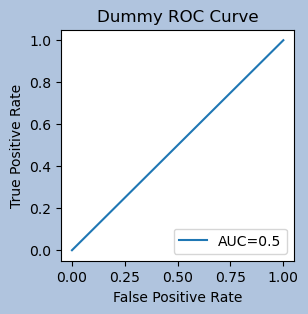

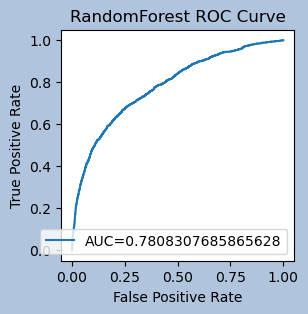

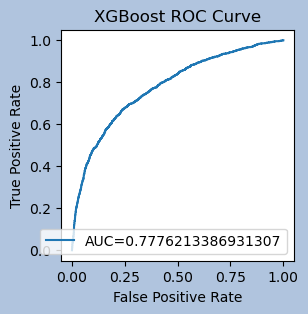

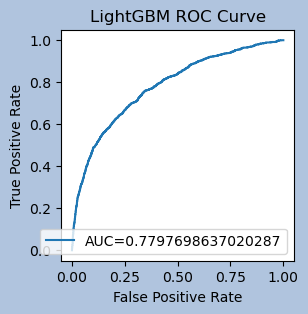

In [ ]:
summary_df = run_classification_models_summary(
    df_clasif,
    use_balanced_pipeline=False,
    plot_metrics=True,
    plot_threshold=False
)

display(summary_df)